In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# 初始化伪造数据工具
fake = Faker("zh_CN")

# 生成1000条模拟数据（UGC与PGC各500条）
data = []
for _ in range(500):  # UGC数据
    data.append({
        "content_type": "UGC",
        "title": f"{fake.word()}穿搭分享",
        "text": f"今天买了{fake.company()}的{fake.word()}，{fake.sentence()}",
        "likes": random.randint(10, 5000),
        "favorites": random.randint(5, 2000),
        "comments": random.randint(0, 500),
        "has_image": random.choice([True, False]),
        "hashtags": "#" + fake.word() + " #" + fake.word(),
        "publish_time": fake.date_time_this_year()
    })

for _ in range(500):  # PGC数据
    data.append({
        "content_type": "PGC",
        "title": f"官方活动：{fake.sentence()}",
        "text": f"点击链接参与{fake.company()}的限时活动：{fake.url()}",
        "likes": random.randint(100, 3000),
        "favorites": random.randint(50, 1500),
        "comments": random.randint(10, 300),
        "has_image": True,  # 品牌内容通常带图
        "hashtags": "#官方活动 #" + fake.word(),
        "publish_time": fake.date_time_this_year()
    })

df = pd.DataFrame(data)
df.to_csv("xiaohongshu_simulated_data.csv", index=False)

In [10]:
# 数据预处理与特征工程完整流程
import pandas as pd
import numpy as np
import re
from collections import Counter
import requests
import os

# 1. 加载模拟数据
df = pd.read_csv('xiaohongshu_simulated_data.csv')

# 2. 数据清洗
print("原始数据量:", len(df))

# 2.1 去重
df = df.drop_duplicates(subset=['title', 'text'])  # 根据标题和正文去重
print("去重后数据量:", len(df))

# 2.2 去标签（去除#标签）
def remove_hashtags(text):
    return re.sub(r'#\w+', '', str(text))

df['text'] = df['text'].apply(remove_hashtags)
df['title'] = df['title'].apply(remove_hashtags)

# 2.3 去链接（去除URL）
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', str(text))

df['text'] = df['text'].apply(remove_urls)
df['title'] = df['title'].apply(remove_urls)

# 2.4 缺失值处理
print("缺失值统计:")
print(df.isnull().sum())

df = df.dropna()  # 删除含有缺失值的行
df = df.reset_index(drop=True)  # 重置索引

# 3. 特征工程
# 3.1 提取文本长度
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['title_length'] = df['title'].apply(lambda x: len(str(x)))

# 3.2 中文分词和关键词提取
# 下载或加载停用词表
stopwords_path = "stopwords.txt"
if not os.path.exists(stopwords_path):
    try:
        stopwords_url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"
        response = requests.get(stopwords_url)
        with open(stopwords_path, "w", encoding="utf-8") as f:
            f.write(response.text)
    except:
        print("下载停用词表失败，使用默认停用词")
        stopwords = set(["的", "了", "和", "是", "在"])
else:
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)

# 补充停用词
extra_stopwords = {'傥', '兼', '唷', '啪', '嘟', '喔', '前', '嘟', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'}
stopwords.update(extra_stopwords)

# 定义关键词提取函数
def extract_keywords(text, top_n=5):
    words = [word for word in jieba.cut(str(text)) 
             if word not in stopwords and len(word) > 1]
    word_counts = Counter(words)
    return ' '.join([word for word, count in word_counts.most_common(top_n)])

# 提取正文关键词
df['text_keywords'] = df['text'].apply(lambda x: extract_keywords(x))

# 提取标题关键词
df['title_keywords'] = df['title'].apply(lambda x: extract_keywords(x))

# 3.3 使用TF-IDF提取重要特征（修改后的版本）
# 自定义分词函数，整合停用词过滤
def chinese_tokenizer(text):
    words = [word for word in jieba.cut(text) 
             if word not in stopwords and len(word) > 1]
    return words

vectorizer = TfidfVectorizer(
    tokenizer=chinese_tokenizer,  # 使用自定义分词器
    lowercase=False,  # 中文不需要小写转换
    max_features=100  # 限制特征数量
)

tfidf_matrix = vectorizer.fit_transform(df['text'])
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), 
                             columns=vectorizer.get_feature_names_out())

# 将TF-IDF特征合并到原数据
df = pd.concat([df, tfidf_features.add_prefix('tfidf_')], axis=1)

# 4. 保存处理后的数据
df.to_csv('xiaohongshu_processed_data.csv', index=False, encoding='utf-8-sig')

# 5. 显示处理后的数据样例
print("\n处理后的数据样例:")
print(df.head(3))

# 6. 基本统计信息
print("\n关键统计信息:")
print(f"UGC数量: {len(df[df['content_type']=='UGC'])}")
print(f"PGC数量: {len(df[df['content_type']=='PGC'])}")
print("\n文本长度统计:")
print(df['text_length'].describe())

原始数据量: 1000
去重后数据量: 1000
缺失值统计:
content_type    0
title           0
text            0
likes           0
favorites       0
comments        0
has_image       0
hashtags        0
publish_time    0
dtype: int64

处理后的数据样例:
  content_type   title                           text  likes  favorites  \
0          UGC  是一穿搭分享  今天买了艾提科信传媒有限公司的状态，一样技术决定地址认为.   2826       1680   
1          UGC  地区穿搭分享    今天买了万迅电脑信息有限公司的一种，等级一下关于准备.   3051        389   
2          UGC  特别穿搭分享    今天买了群英科技有限公司的单位，能力点击以及那些希望.   3849        735   

   comments  has_image hashtags         publish_time  text_length  ...  \
0       324      False  #大学 #拥有  2025-03-14 06:26:22           29  ...   
1       282      False  #正在 #国内  2025-01-03 17:56:25           27  ...   
2       285      False  #电影 #行业  2025-01-15 20:39:02           27  ...   

   tfidf_进入 tfidf_选择 tfidf_部分  tfidf_金承  tfidf_银嘉  tfidf_链接  tfidf_限时  \
0       0.0      0.0      0.0       0.0       0.0       0.0       0.0   
1       0.0      0.0      0.0       0.

E:\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


内容类型分布:
 UGC    0.5
PGC    0.5
Name: content_type, dtype: float64

互动指标统计:
                  likes               favorites             comments      
                  mean  median   max      mean         std     mean count
content_type                                                             
PGC           1532.320  1454.0  2988   751.410  429.654857  154.570   500
UGC           2488.574  2485.5  4990   968.628  575.101132  248.634   500


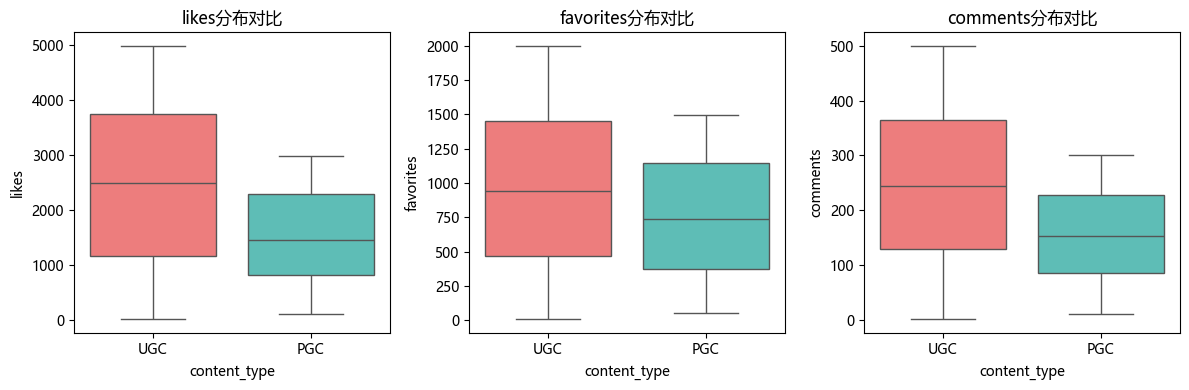

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 全局设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows用户修改此处
plt.rcParams['axes.unicode_minus'] = False

# 2. 加载数据
df = pd.read_csv('xiaohongshu_processed_data.csv')

# 3. 统计分析
content_dist = df['content_type'].value_counts(normalize=True)
print("内容类型分布:\n", content_dist)

interaction_stats = df.groupby('content_type').agg({
    'likes': ['mean', 'median', 'max'],
    'favorites': ['mean', 'std'],
    'comments': ['mean', 'count']
})
print("\n互动指标统计:\n", interaction_stats)

# 4. 可视化
plt.figure(figsize=(12,4))
for i, col in enumerate(['likes', 'favorites', 'comments']):
    plt.subplot(1,3,i+1)
    sns.boxplot(
        data=df,
        x='content_type',
        y=col,
        hue='content_type',  # 关键修正
        palette=['#FF6B6B', '#4ECDC4'],
        legend=False
    )
    plt.title(f'{col}分布对比')  # 中文正常显示
plt.tight_layout()
plt.show()

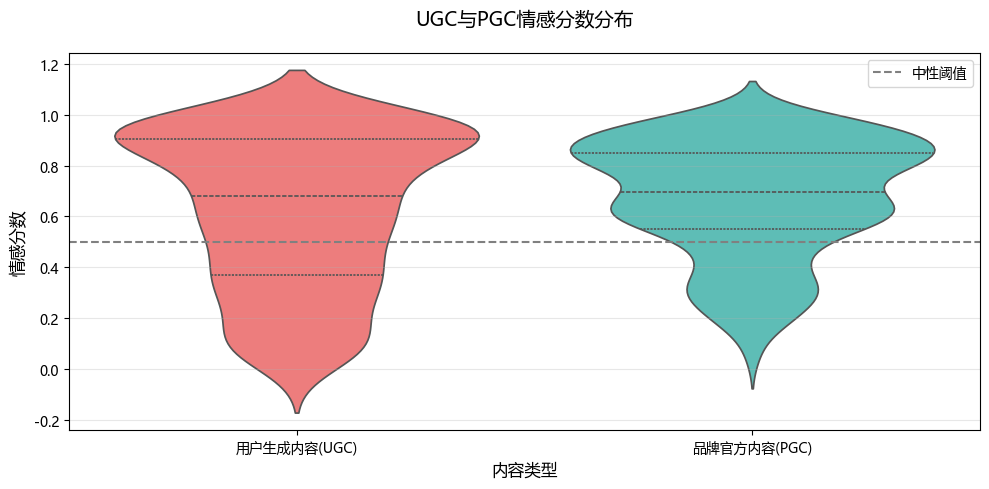

In [10]:
import pandas as pd
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 情感分析函数
def analyze_sentiment(text):
    """计算文本情感分数（0负面~1正面）"""
    s = SnowNLP(str(text))
    return s.sentiments

# 应用情感分析
df['sentiment'] = df['text'].apply(analyze_sentiment)

# 2. 情感分布可视化
plt.figure(figsize=(10, 5))

# 关键修改：将x变量赋给hue，并设置legend=False
sns.violinplot(
    data=df,
    x='content_type', 
    y='sentiment',
    hue='content_type',  # 新增hue参数
    palette=['#FF6B6B', '#4ECDC4'],  # UGC红色，PGC青色
    inner='quartile',
    legend=False  # 避免重复图例
)

# 添加辅助线和样式
plt.axhline(0.5, color='gray', linestyle='--', label='中性阈值')
plt.title('UGC与PGC情感分数分布', fontsize=14, pad=20)
plt.xlabel('内容类型', fontsize=12)
plt.ylabel('情感分数', fontsize=12)
plt.xticks([0, 1], ['用户生成内容(UGC)', '品牌官方内容(PGC)'])
plt.grid(axis='y', alpha=0.3)

# 显示图例（只显示中性阈值）
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
from snownlp import SnowNLP

# 情感分析函数
def analyze_sentiment(text):
    return SnowNLP(str(text)).sentiments  # 返回0(负面)~1(正面)

# 应用情感分析
if 'sentiment' not in df.columns:
    df['sentiment'] = df['text'].apply(analyze_sentiment)
    df.to_csv('xiaohongshu_processed_data.csv', index=False)  # 保存结果

模型MSE: 1469355.31
特征权重: {'text_length': -73.00535239466693, 'sentiment': 16.232576163853025, 'hour': 40.07553072145561, 'has_image': -30.590635558446834, 'content_type_PGC': -267.6542005412829, 'content_type_UGC': 267.6542005412827}


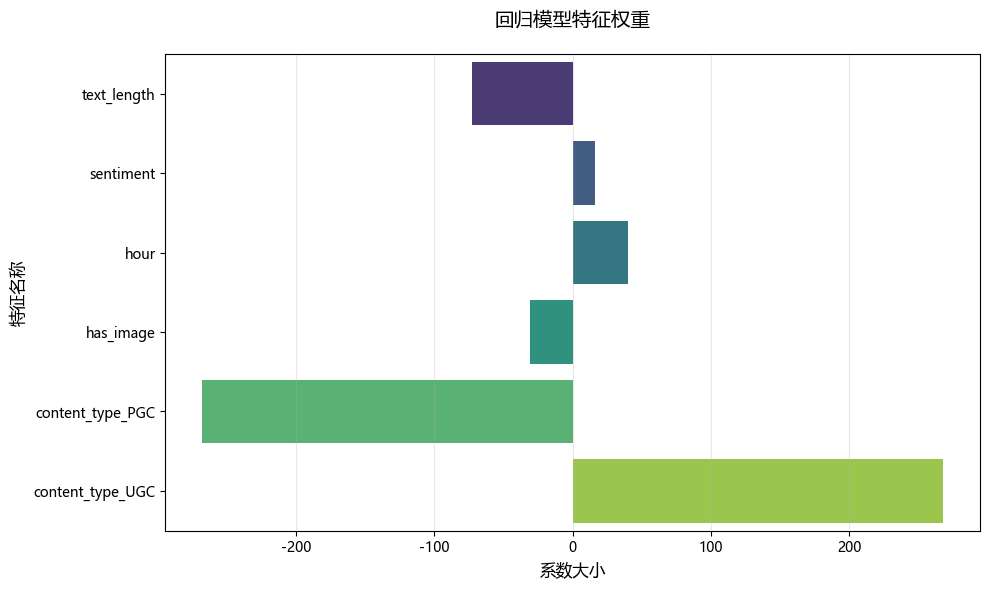

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. 特征工程
def feature_engineering(df):
    """特征预处理函数"""
    # 时间特征提取
    df['hour'] = pd.to_datetime(df['publish_time']).dt.hour
    
    # 类型转换
    df['has_image'] = df['has_image'].astype(int)
    
    # 选择特征列
    features = ['text_length', 'sentiment', 'hour', 'has_image', 'content_type']
    
    # 独热编码
    X = pd.get_dummies(df[features], columns=['content_type']) 
    y = df['likes']
    
    return X, y

# 2. 模型训练与评估
def train_model(X, y):
    """模型训练与评估函数"""
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # 训练模型
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 模型评估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return model, mse

# 3. 可视化
def plot_feature_importance(model, X):
    """特征重要性可视化（解决FutureWarning）"""
    plt.figure(figsize=(10, 6))
    
    # 关键修改：将y变量赋给hue，并禁用图例
    sns.barplot(
        x=model.coef_,
        y=X.columns,
        hue=X.columns,  # 新增hue参数
        palette='viridis',
        legend=False    # 避免重复图例
    )
    
    # 可视化优化
    plt.title('回归模型特征权重', fontsize=14, pad=20)
    plt.xlabel('系数大小', fontsize=12)
    plt.ylabel('特征名称', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 主流程
if __name__ == "__main__":
    # 加载数据
    df = pd.read_csv('xiaohongshu_processed_data.csv') 
    
    # 执行全流程
    X, y = feature_engineering(df)
    model, mse = train_model(X, y)
    
    # 输出结果
    print(f"模型MSE: {mse:.2f}")
    print("特征权重:", dict(zip(X.columns, model.coef_)))
    
    # 可视化
    plot_feature_importance(model, X)

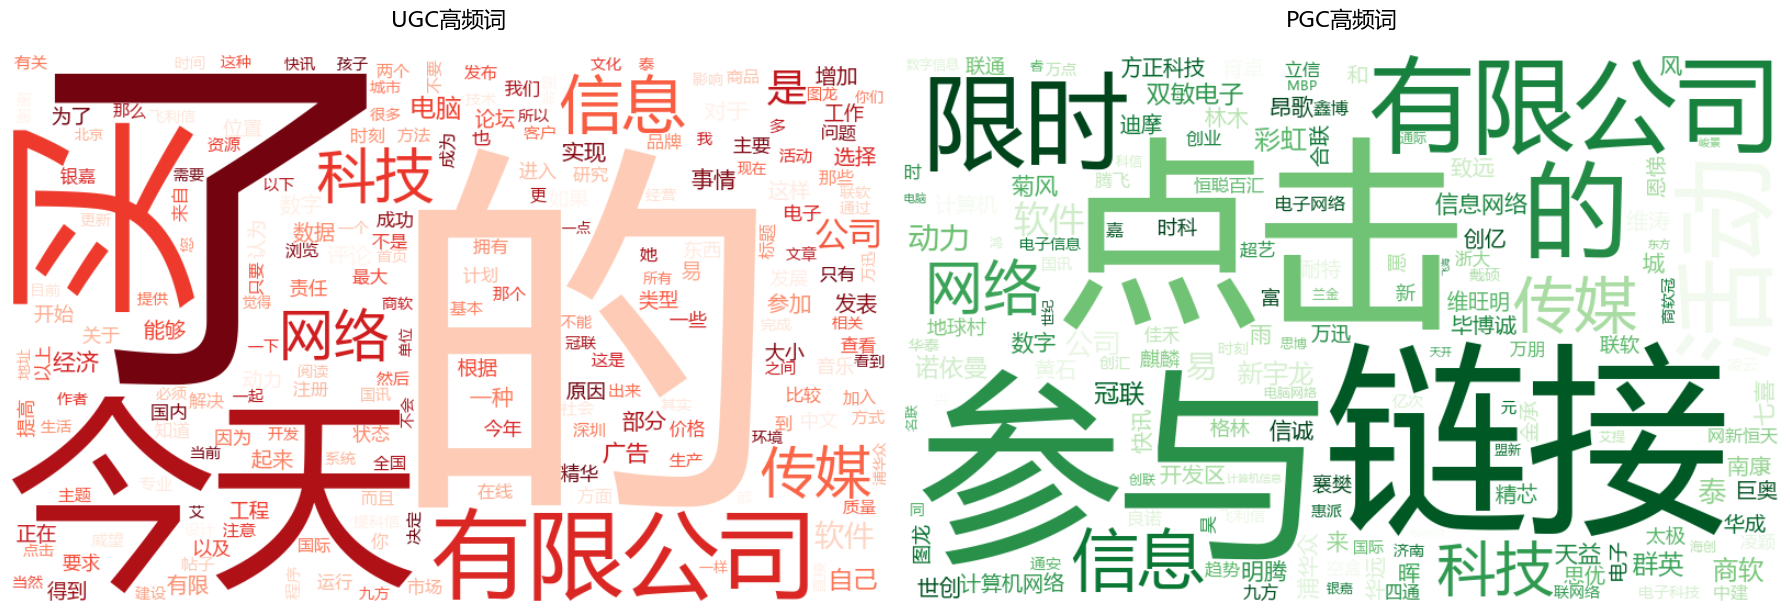

In [21]:
import pandas as pd
import re
import jieba
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager
import warnings

# 忽略警告
warnings.filterwarnings("ignore")

# 1. 字体解决方案（自动检测可用中文字体）
def get_chinese_font():
    """获取系统中可用的中文字体"""
    try:
        # 查找系统字体
        system_fonts = font_manager.findSystemFonts()
        
        # 优先尝试常见中文字体
        for font_name in ['msyh.ttc', 'simhei.ttf', 'simsun.ttc', 'PingFang.ttc']:
            for font_path in system_fonts:
                if font_name.lower() in font_path.lower():
                    return font_path
        
        # 如果找不到，尝试下载字体
        try:
            import requests
            import os
            font_url = "https://github.com/googlefonts/noto-cjk/raw/main/Sans/NotoSansCJK-Regular.ttc"
            local_font = "NotoSansCJK.ttc"
            if not os.path.exists(local_font):
                r = requests.get(font_url)
                with open(local_font, 'wb') as f:
                    f.write(r.content)
            return local_font
        except:
            return None
    except:
        return None

# 获取字体路径
font_path = get_chinese_font()

# 2. 数据加载与预处理
def load_and_preprocess(file_path):
    """加载并预处理数据"""
    df = pd.read_csv(file_path)
    
    # 文本清洗
    def clean_text(text):
        text = re.sub(r'#\w+', '', str(text))  # 去标签
        text = re.sub(r'http\S+|www\.\S+', '', text)  # 去链接
        text = re.sub(r'[^\w\s]', '', text)  # 去标点
        return text.strip()
    
    df['clean_text'] = df['text'].apply(clean_text)
    
    # 中文分词（带异常处理）
    def chinese_tokenizer(text):
        try:
            return ' '.join(jieba.cut(str(text)))
        except:
            return ''
    
    df['tokenized_text'] = df['clean_text'].apply(chinese_tokenizer)
    return df

# 3. 安全生成词云函数
def safe_generate_wordcloud(text_series, title, colormap):
    """安全生成词云"""
    # 合并文本并过滤空值
    full_text = ' '.join([str(t) for t in text_series if pd.notna(t) and str(t).strip()])
    
    if not full_text:
        print(f"警告：{title}无有效文本内容")
        return None
    
    try:
        wc = WordCloud(
            font_path=font_path,
            background_color='white',
            colormap=colormap,
            width=800,
            height=500,
            max_words=200,
            collocations=False  # 避免重复词
        )
        return wc.generate(full_text)
    except Exception as e:
        print(f"生成{title}词云失败:", str(e))
        return None

# 4. 主函数
def main():
    # 加载数据
    df = load_and_preprocess('xiaohongshu_processed_data.csv')
    
    # 创建画布
    plt.figure(figsize=(18, 8))
    
    # UGC词云
    plt.subplot(1, 2, 1)
    wc_ugc = safe_generate_wordcloud(
        df[df['content_type']=='UGC']['tokenized_text'],
        'UGC词云',
        'Reds'
    )
    if wc_ugc:
        plt.imshow(wc_ugc, interpolation='bilinear')
        plt.title('UGC高频词', fontsize=16, pad=20)
    plt.axis("off")
    
    # PGC词云
    plt.subplot(1, 2, 2)
    wc_pgc = safe_generate_wordcloud(
        df[df['content_type']=='PGC']['tokenized_text'],
        'PGC词云',
        'Greens'
    )
    if wc_pgc:
        plt.imshow(wc_pgc, interpolation='bilinear')
        plt.title('PGC高频词', fontsize=16, pad=20)
    plt.axis("off")
    
    # 调整布局并显示
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

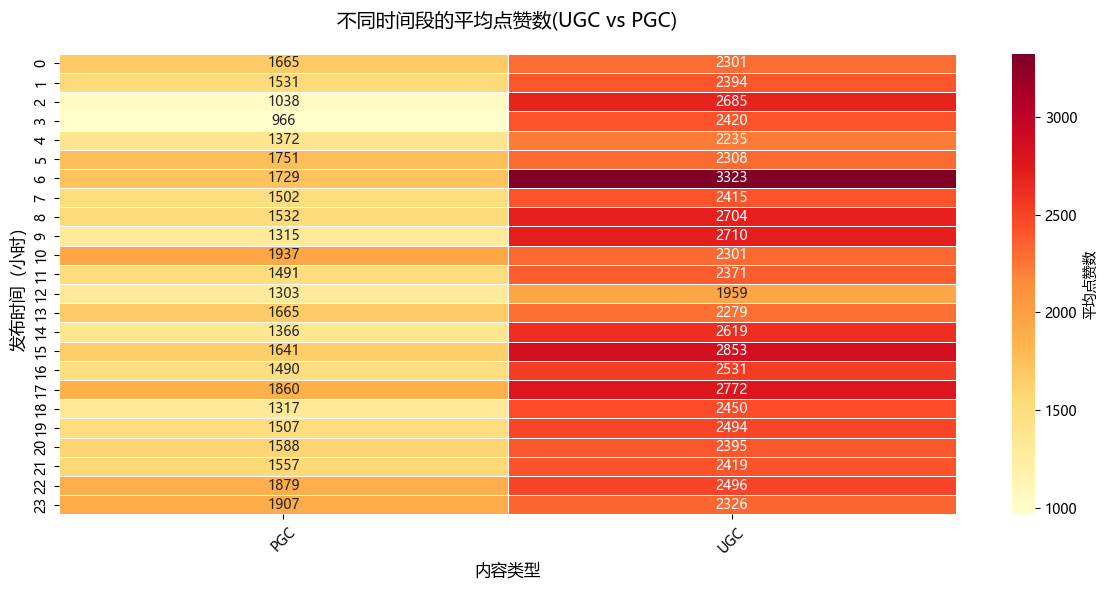

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载数据
df = pd.read_csv('xiaohongshu_processed_data.csv')

# 2. 时间列转换（关键修正）
try:
    # 尝试自动转换时间格式
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    
    # 验证转换是否成功
    if not pd.api.types.is_datetime64_any_dtype(df['publish_time']):
        # 如果自动转换失败，尝试指定格式
        df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%d %H:%M:%S')
except Exception as e:
    print(f"时间转换失败，请检查数据格式。错误信息: {e}")
    # 显示前5行时间数据供检查
    print("时间列样例数据:")
    print(df['publish_time'].head())

# 3. 提取小时数
if pd.api.types.is_datetime64_any_dtype(df['publish_time']):
    df['hour'] = df['publish_time'].dt.hour
else:
    raise ValueError("时间列转换失败，无法提取小时数")

# 4. 创建透视表
heatmap_data = df.pivot_table(
    index='hour',
    columns='content_type',
    values='likes',
    aggfunc='mean'
)

# 5. 绘制热力图
plt.figure(figsize=(12, 6))  # 增大图形尺寸
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',  # 修正颜色映射名称
    annot=True,
    fmt='.0f',     # 修正格式字符串
    linewidths=0.5,
    cbar_kws={'label': '平均点赞数'}
)

# 6. 添加图表标签
plt.title('不同时间段的平均点赞数(UGC vs PGC)', fontsize=14, pad=20)
plt.xlabel('内容类型', fontsize=12)
plt.ylabel('发布时间（小时）', fontsize=12)
plt.xticks(rotation=45)  # x轴标签旋转45度

plt.tight_layout()  # 自动调整布局
plt.show()